# 01 - Feature Extraction

This notebook performs feature extraction for the Infant Audio Classifier project. It loads infant audio samples, applies noise reduction, extracts multiple audio features, and prepares a clean dataset for further analysis and modeling.  


## Importing Libraries

In [1]:
# Install required packages
!pip install noisereduce pydub --quiet

# Core Utilities
import os
import glob
import io
import random
import time
import warnings

# Data Processing
import numpy as np
import pandas as pd

# Audio Processing
import librosa
import soundfile as sf
from pydub import AudioSegment
import noisereduce as nr

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio

# Machine Learning Tools
from sklearn.preprocessing import LabelEncoder

# Progress Tracking
from tqdm.notebook import tqdm

# Suppress unnecessary warnings
warnings.filterwarnings("ignore")

## Mount Google Drive

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load and Organize Audio Data

In [3]:
# Define dataset path and class names
path = '/content/drive/MyDrive/data'
subfolders = ['laugh', 'noise', 'silence']

# Initialize dictionaries to store audio signals and labels
audio_data_by_class = {cls: [] for cls in subfolders}
labels_by_class = {cls: [] for cls in subfolders}

# Load all audio files for each class
for cls in subfolders:
    subfolder_path = os.path.join(path, cls)
    audio_files = glob.glob(os.path.join(subfolder_path, '*.ogg')) + glob.glob(os.path.join(subfolder_path, '*.wav'))

    for file in audio_files:
        audio, sr = librosa.load(file, sr=None)  # Load audio with its native sampling rate
        audio_data_by_class[cls].append(audio)
        labels_by_class[cls].append(cls)

# Print summary of loaded data
for cls in subfolders:
    print(f"Class: {cls}")
    print(f"Audio Samples: {len(audio_data_by_class[cls])}")
    print(f"Labels: {len(labels_by_class[cls])}\n")

Class: laugh
Audio Samples: 108
Labels: 108

Class: noise
Audio Samples: 108
Labels: 108

Class: silence
Audio Samples: 108
Labels: 108



## Define Audio Visualization and Feature Utility Functions

In [4]:
import os, glob
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# Plot waveform
def plot_waveform(audio_data, title):
    plt.figure(figsize=(10, 4))
    plt.plot(audio_data, color='b')
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

# Play audio sample
def play_audio(audio_data, sr):
    return Audio(audio_data, rate=sr)

# Plot mel spectrogram
def plot_spectrogram(audio_data, sr, title):
    plt.figure(figsize=(10, 4))
    spec = librosa.feature.melspectrogram(y=audio_data, sr=sr)
    librosa.display.specshow(librosa.power_to_db(spec, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

# Plot amplitude envelope using STFT
def plot_amplitude_envelope(audio_data, sr, title):
    envelope = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(envelope, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

# Plot spectral centroid over time
def plot_spectral_centroid(audio_data, sr, title):
    centroids = librosa.feature.spectral_centroid(y=audio_data, sr=sr)[0]
    t = librosa.frames_to_time(range(len(centroids)))
    plt.figure(figsize=(10, 4))
    plt.plot(t, centroids, color='r')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Spectral Centroid')
    plt.show()

# Plot spectral contrast features
def plot_spectral_contrast(audio_data, sr, title):
    contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sr)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(contrast, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title(title)
    plt.ylabel('Frequency Bands')
    plt.xlabel('Time')
    plt.show()

# Plot chroma features
def plot_chroma_features(audio_data, sr, title):
    chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(chroma, x_axis='time', sr=sr, cmap='coolwarm')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Plot zero-crossing rate (ZCR)
def plot_zcr(audio_data, title):
    zcr = librosa.feature.zero_crossing_rate(y=audio_data)
    plt.figure(figsize=(10, 4))
    plt.plot(zcr[0], color='b')
    plt.title(title)
    plt.xlabel('Frame')
    plt.ylabel('Zero-Crossing Rate')
    plt.show()

# Plot ZCR alongside waveform
def plot_zcr_with_waveform(audio_data, sr, title):
    zcr = librosa.feature.zero_crossing_rate(y=audio_data)
    plt.figure(figsize=(10, 6))
    plt.plot(audio_data, color='b', label='Waveform')
    plt.plot(zcr[0] * np.max(np.abs(audio_data)), color='r', label='Zero-Crossing Rate')
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude / ZCR')
    plt.legend()
    plt.show()

# Plot tempo distribution
def estimate_tempo_and_plot_distribution(tempos, title):
    plt.figure(figsize=(8, 4))
    plt.hist(tempos, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel('Tempo (BPM)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Compute Harmonics-to-Noise Ratio (HNR)
def compute_hnr(audio_data):
    hnr = librosa.effects.harmonic(audio_data)
    noise = audio_data - hnr
    return np.mean(np.abs(hnr)) / np.mean(np.abs(noise))

# Calculate Signal-to-Noise Ratio (SNR)
def calculate_snr(audio_data):
    signal_power = np.sqrt(np.mean(audio_data ** 2))
    noise_power = np.mean(np.abs(audio_data))
    return 20 * np.log10(signal_power / noise_power)

## Load Audio Samples and Visualize Features

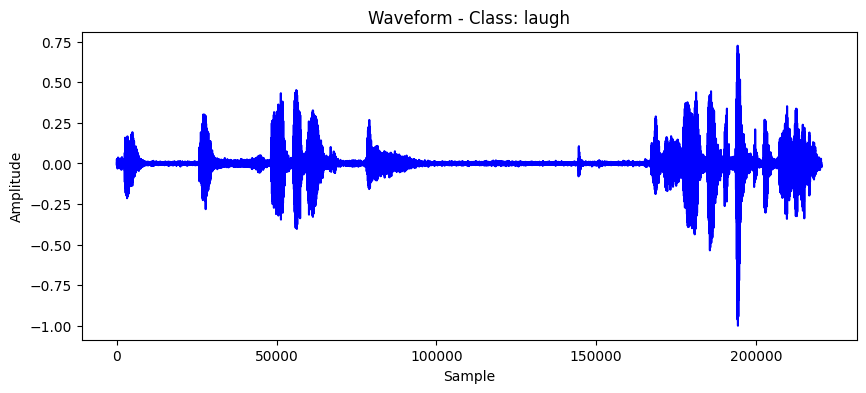

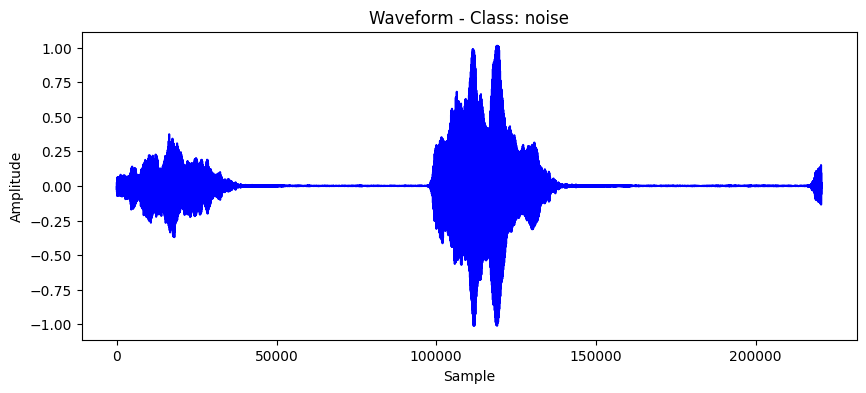

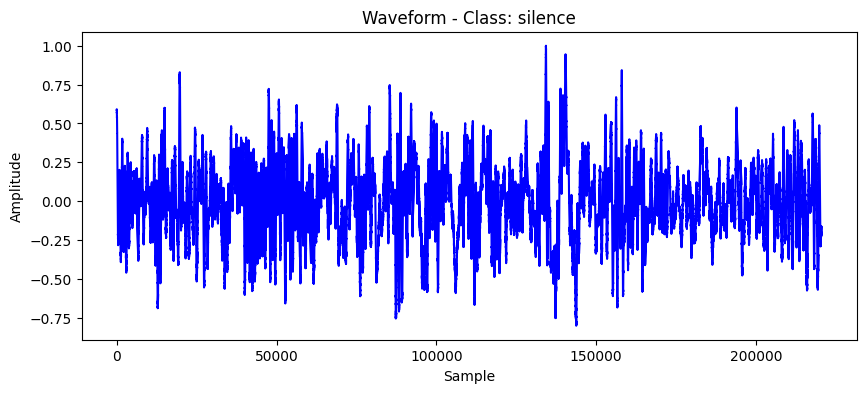

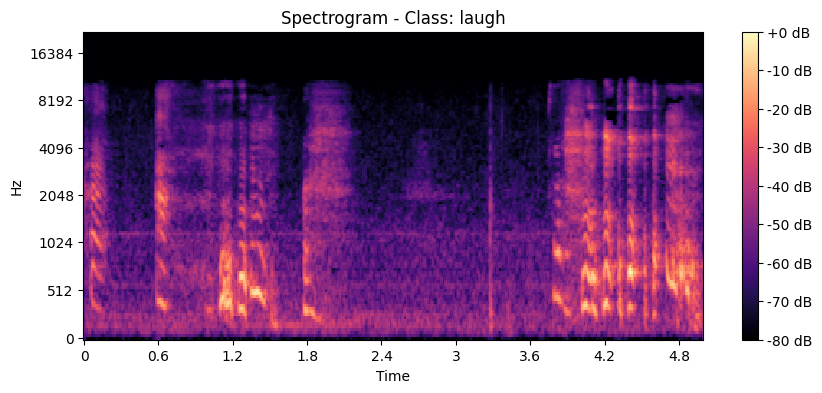

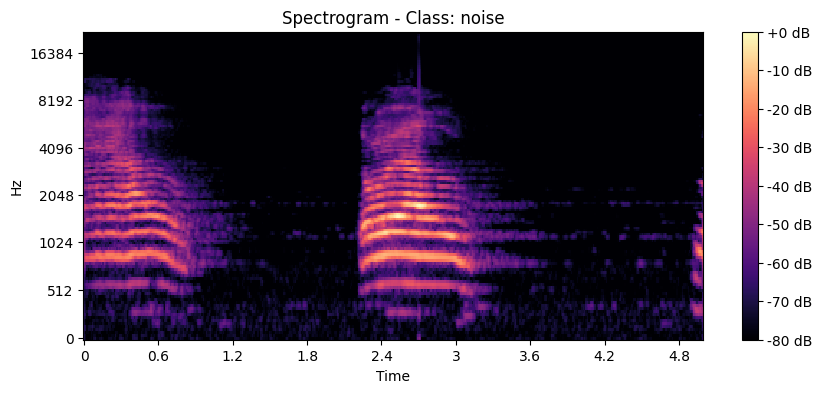

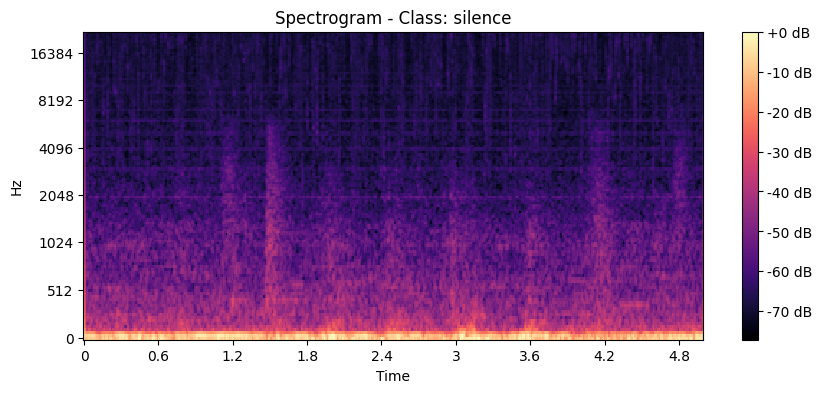

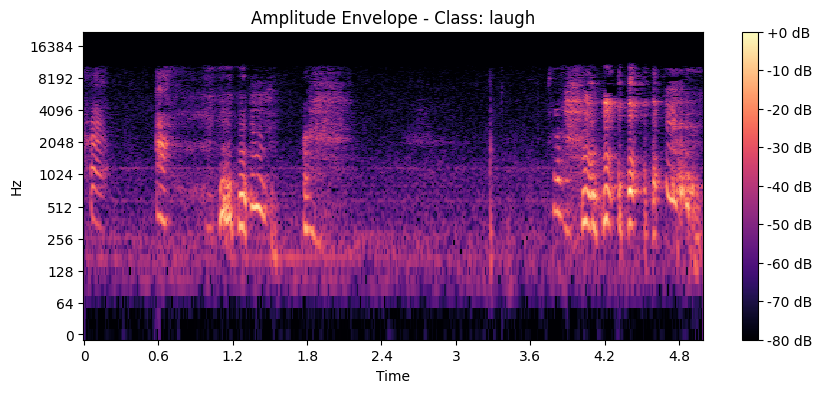

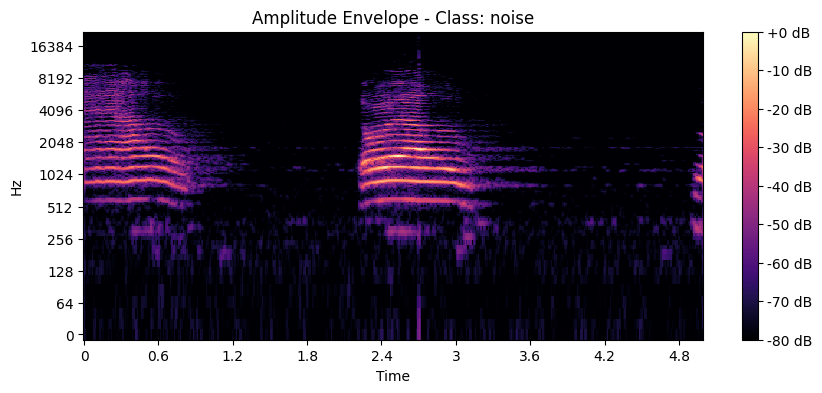

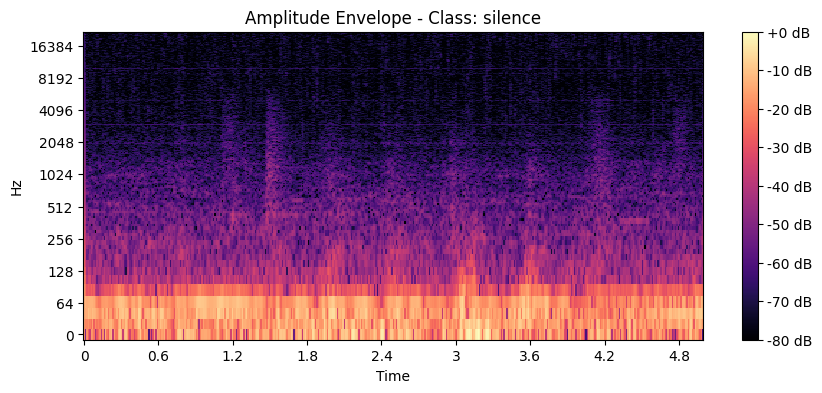

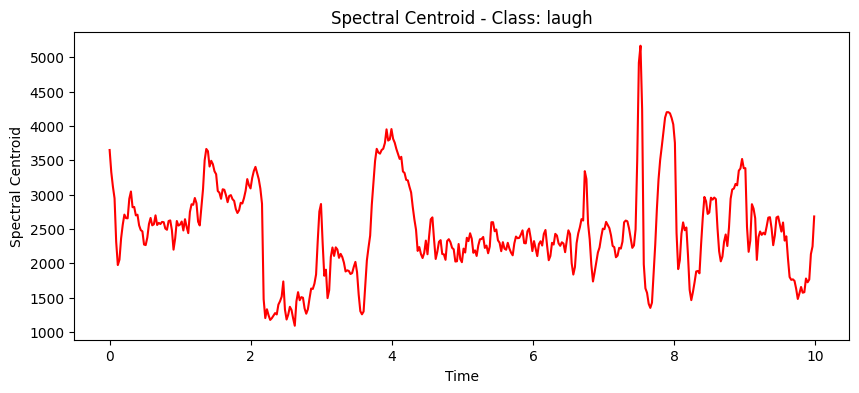

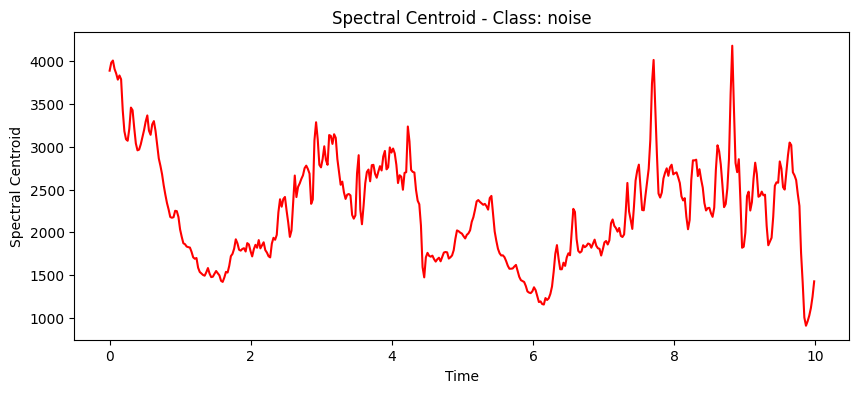

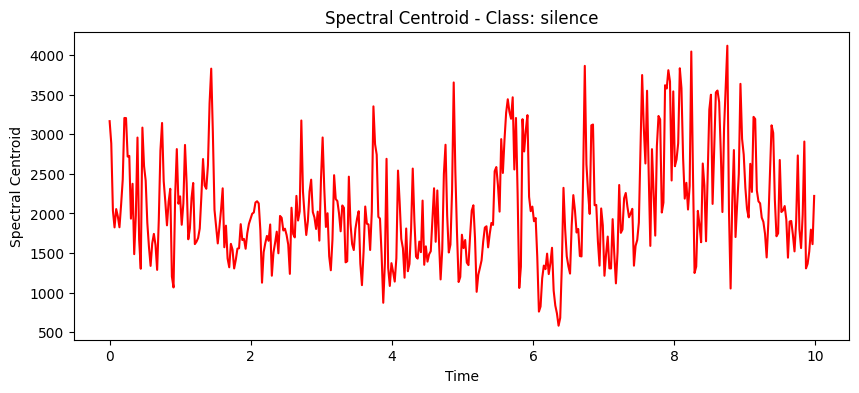

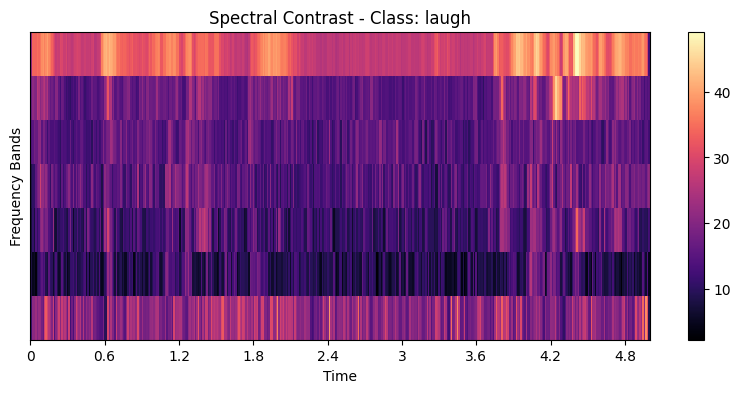

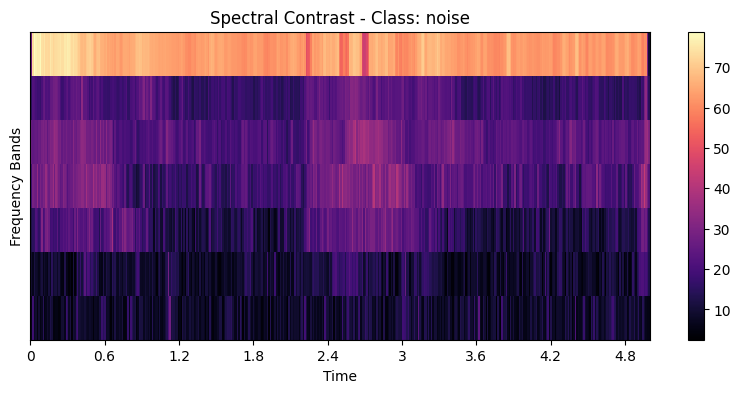

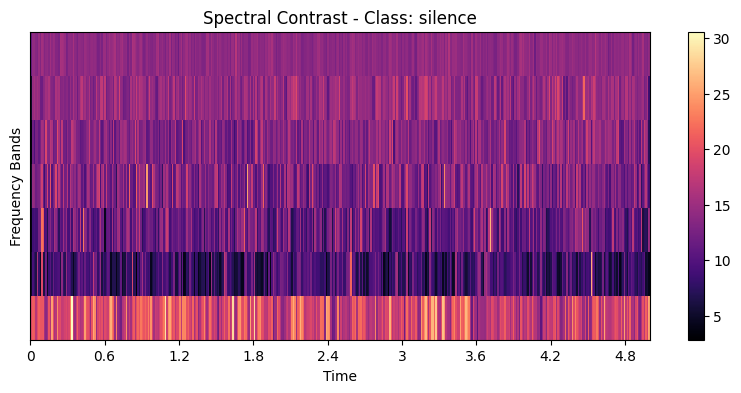

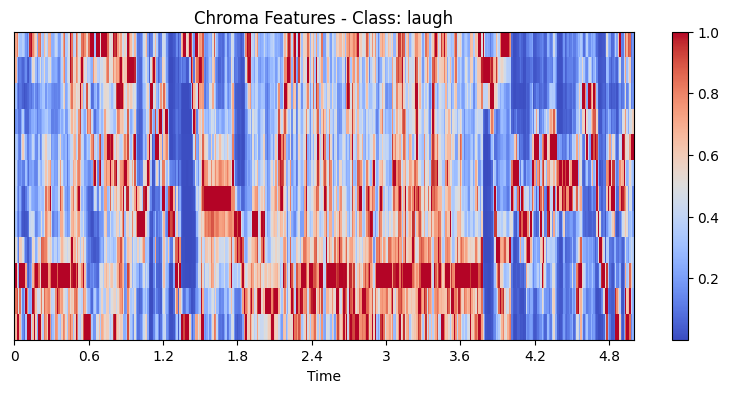

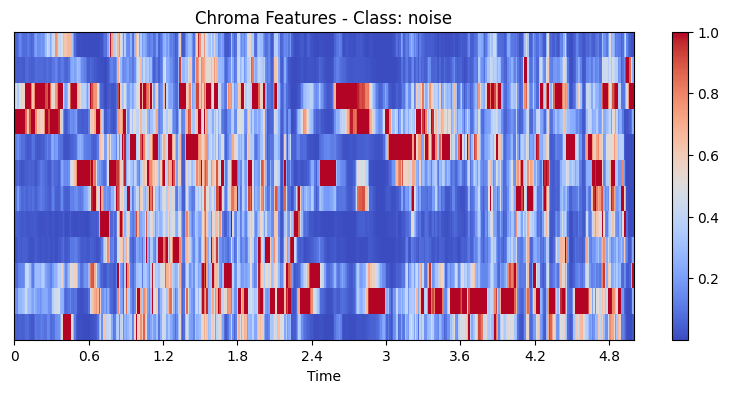

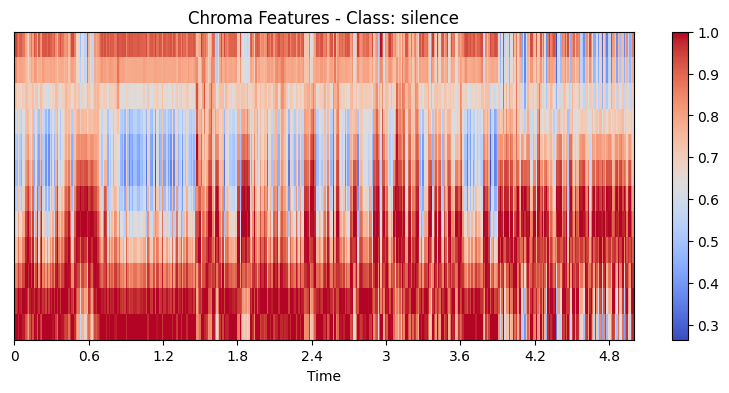

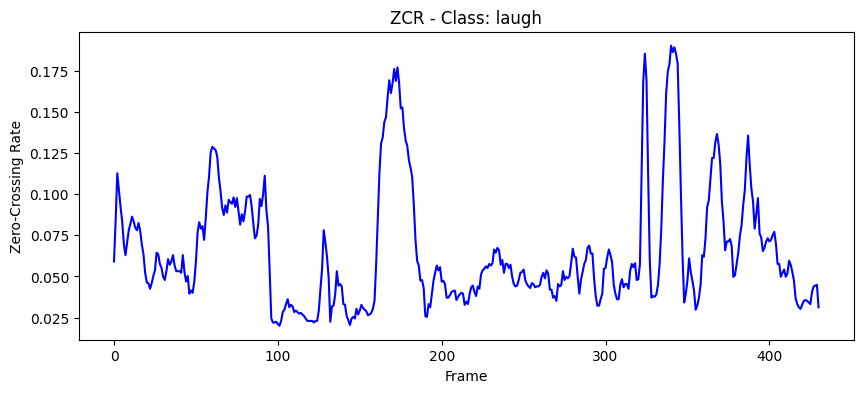

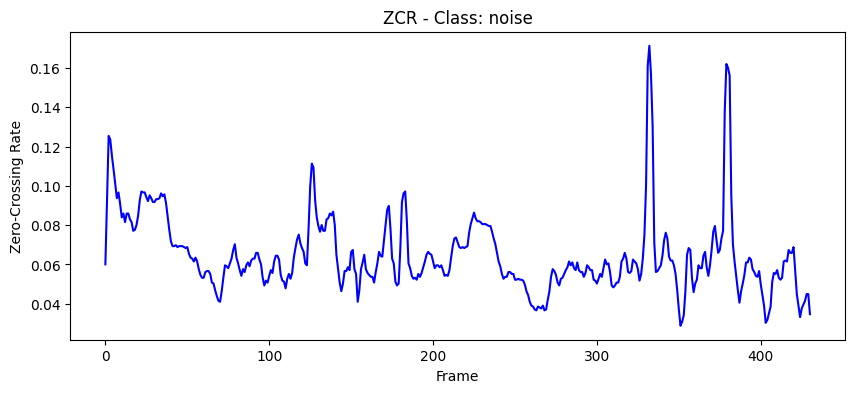

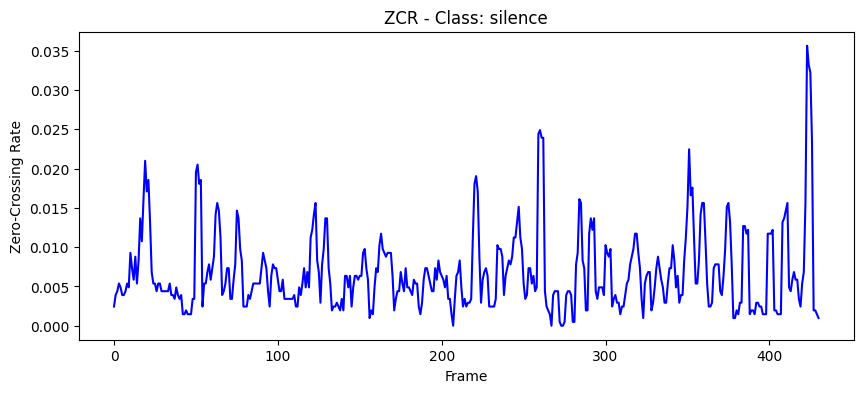

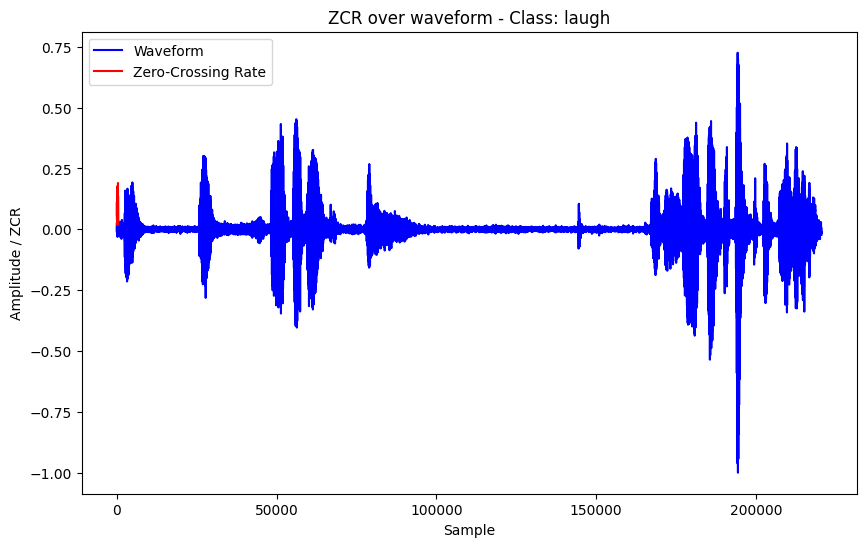

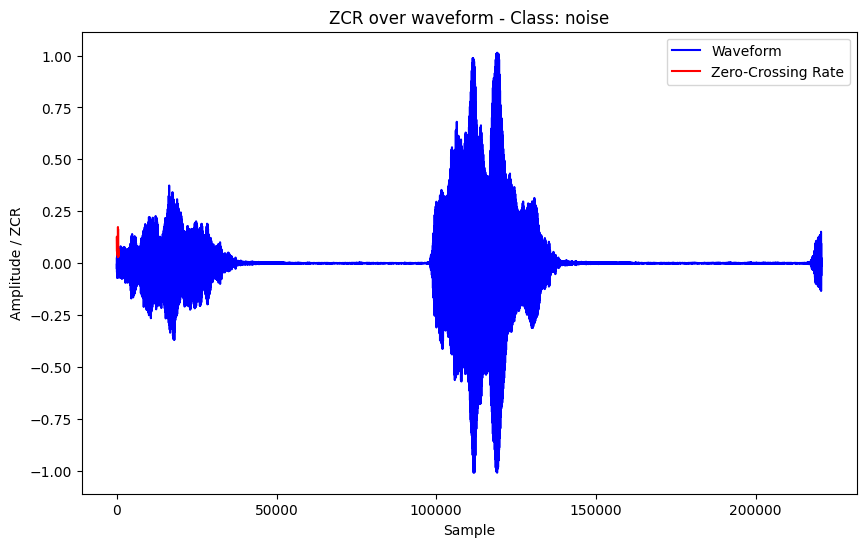

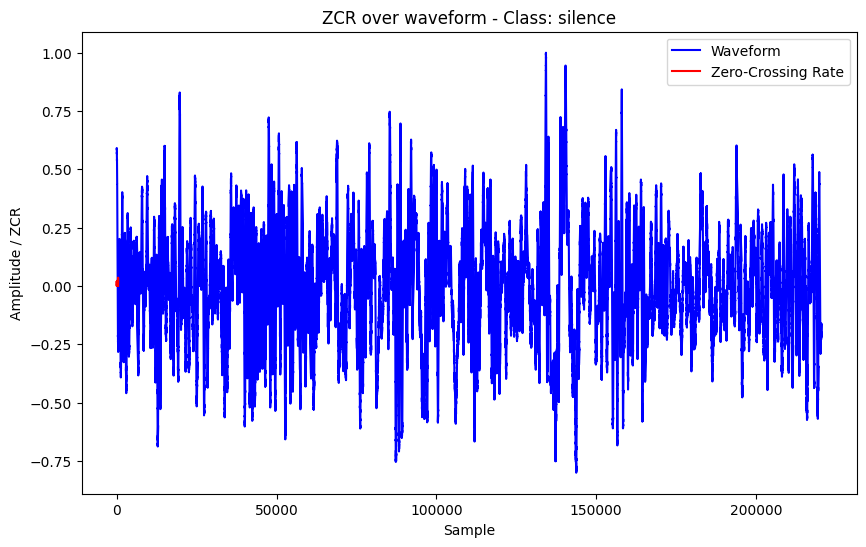

Class: laugh | HNR: 1.234 | SNR: 6.82 dB
Class: noise | HNR: 6.647 | SNR: 8.41 dB
Class: silence | HNR: 26.866 | SNR: 2.01 dB


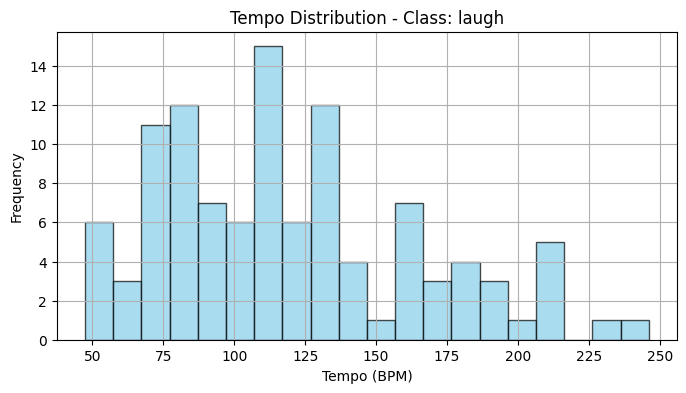

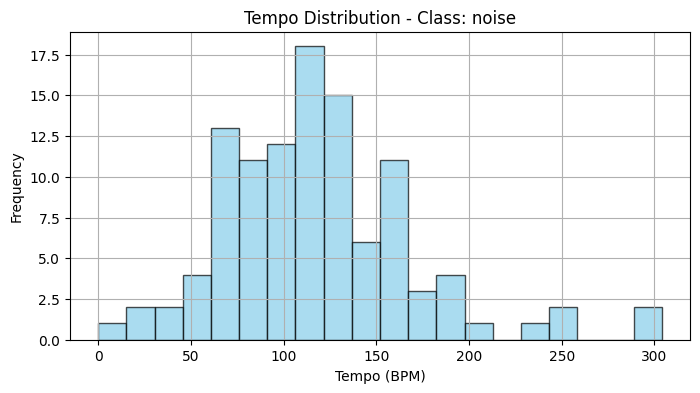

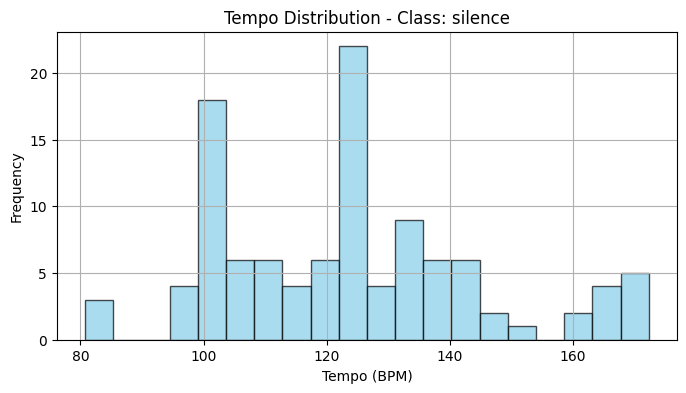

In [5]:
# Load one sample from each class
audio_samples = {}

for subfolder in subfolders:
    subfolder_path = os.path.join(path, subfolder)
    audio_files = glob.glob(os.path.join(subfolder_path, '*.ogg')) + glob.glob(os.path.join(subfolder_path, '*.wav'))
    if not audio_files:
        continue
    audio_file = audio_files[0]
    audio_data, sr = librosa.load(audio_file, sr=None)
    audio_samples[subfolder] = (audio_data, sr)

# Plot waveforms for each class
for cls, (audio_data, sr) in audio_samples.items():
    plot_waveform(audio_data, f'Waveform - Class: {cls}')
    display(play_audio(audio_data, sr))

# Plot spectrograms for each class
for cls, (audio_data, sr) in audio_samples.items():
    plot_spectrogram(audio_data, sr, f'Spectrogram - Class: {cls}')

# Plot amplitude envelopes
for cls, (audio_data, sr) in audio_samples.items():
    plot_amplitude_envelope(audio_data, sr, f'Amplitude Envelope - Class: {cls}')

# Plot spectral centroids
for cls, (audio_data, sr) in audio_samples.items():
    plot_spectral_centroid(audio_data, sr, f'Spectral Centroid - Class: {cls}')

# Plot spectral contrasts
for cls, (audio_data, sr) in audio_samples.items():
    plot_spectral_contrast(audio_data, sr, f'Spectral Contrast - Class: {cls}')

# Plot chroma features
for cls, (audio_data, sr) in audio_samples.items():
    plot_chroma_features(audio_data, sr, f'Chroma Features - Class: {cls}')

# Plot zero-crossing rate (ZCR)
for cls, (audio_data, sr) in audio_samples.items():
    plot_zcr(audio_data, f'ZCR - Class: {cls}')

# Plot ZCR over waveform
for cls, (audio_data, sr) in audio_samples.items():
    plot_zcr_with_waveform(audio_data, sr, f'ZCR over waveform - Class: {cls}')

# Compute and display HNR and SNR for each class
for cls, (audio_data, sr) in audio_samples.items():
    hnr = compute_hnr(audio_data)
    snr = calculate_snr(audio_data)
    print(f'Class: {cls} | HNR: {hnr:.3f} | SNR: {snr:.2f} dB')

# Estimate and plot tempo distribution per class
for subfolder in subfolders:
    subfolder_path = os.path.join(path, subfolder)
    audio_files = os.listdir(subfolder_path)
    tempos = []
    for audio_file in audio_files:
        audio_data, sr = librosa.load(os.path.join(subfolder_path, audio_file), sr=None)
        tempo, _ = librosa.beat.beat_track(y=audio_data, sr=sr)
        tempos.append(float(tempo))
    estimate_tempo_and_plot_distribution(tempos, f'Tempo Distribution - Class: {subfolder}')

## Load All Audio Files and Build Dataset DataFrame

In [6]:
# Get all class subfolders in the dataset directory
subfolders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]

# Initialize storage structures
audio_data_by_class = {sub: [] for sub in subfolders}
labels_by_class = {sub: [] for sub in subfolders}
sampling_rates = {sub: [] for sub in subfolders}

# Load all audio files for each class
for subfolder in subfolders:
    subfolder_path = os.path.join(path, subfolder)
    audio_files = glob.glob(os.path.join(subfolder_path, '*.ogg')) + glob.glob(os.path.join(subfolder_path, '*.wav'))

    for audio_file in audio_files:
        audio_data, sr = sf.read(audio_file)  # Load audio file using soundfile
        audio_data_by_class[subfolder].append(audio_data)
        labels_by_class[subfolder].append(subfolder)
        sampling_rates[subfolder].append(sr)

# Combine all class data into a single DataFrame
dataframes = []
for subfolder in subfolders:
    df_sub = pd.DataFrame({
        'Audio_Data': audio_data_by_class[subfolder],
        'Sampling_Rate': sampling_rates[subfolder],
        'Label': labels_by_class[subfolder]
    })
    dataframes.append(df_sub)

df = pd.concat(dataframes, ignore_index=True)

# Display basic DataFrame information
print(df.info())
display(df.head())

# Display label counts and overall shape
print(df['Label'].value_counts())
print(f"DataFrame shape: {df.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Audio_Data     324 non-null    object
 1   Sampling_Rate  324 non-null    int64 
 2   Label          324 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.7+ KB
None


Audio_Data  Sampling_Rate    Label
0  [0.5868028402328491, 0.5899450182914734, 0.591...          44100  silence
1  [0.044786565005779266, 0.05318404361605644, 0....          44100  silence
2  [0.030365202575922012, 0.029954861849546432, 0...          44100  silence
3  [0.06278210878372192, 0.06401313096284866, 0.0...          44100  silence
4  [0.12333071231842041, 0.13197171688079834, 0.1...          44100  silence

Label
silence    108
noise      108
laugh      108
Name: count, dtype: int64
DataFrame shape: (324, 3)


## Analyze and Visualize Class Distribution

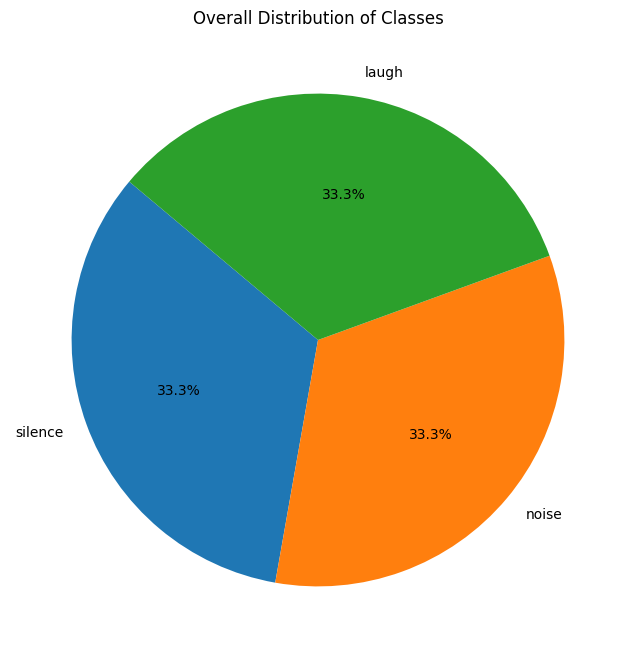

Null values per column:
Audio_Data       0
Sampling_Rate    0
Label            0
dtype: int64


In [7]:
# Count samples per class
class_counts = df['Label'].value_counts()

# Plot class distribution as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Overall Distribution of Classes')
plt.show()

# Check for missing values in the DataFrame
print("Null values per column:")
print(df.isnull().sum())

## Define Noise Reduction Function

In [8]:
# Apply spectral noise reduction to an audio signal
def apply_noise_reduction(audio_data, sampling_rate):
    """
    Perform spectral noise reduction.
    Converts stereo to mono if needed and returns a denoised audio signal.
    """
    if isinstance(audio_data, np.ndarray) and audio_data.ndim > 1:
        audio_data = np.mean(audio_data, axis=1)  # Convert stereo to mono

    reduced_audio = nr.reduce_noise(y=audio_data, sr=sampling_rate)
    return reduced_audio

## Apply Noise Reduction to All Audio Samples

In [9]:
# Enable progress bar for DataFrame operations
tqdm.pandas(desc="Applying Noise Reduction")

# Apply noise reduction to each audio sample and store in a new column
df['Reduced_Audio'] = df.progress_apply(
    lambda row: apply_noise_reduction(row['Audio_Data'], row['Sampling_Rate']), axis=1
)

# Display the updated DataFrame
display(df.head())

Applying Noise Reduction:   0%|          | 0/324 [00:00<?, ?it/s]

Audio_Data  Sampling_Rate    Label  \
0  [0.5868028402328491, 0.5899450182914734, 0.591...          44100  silence   
1  [0.044786565005779266, 0.05318404361605644, 0....          44100  silence   
2  [0.030365202575922012, 0.029954861849546432, 0...          44100  silence   
3  [0.06278210878372192, 0.06401313096284866, 0.0...          44100  silence   
4  [0.12333071231842041, 0.13197171688079834, 0.1...          44100  silence   

                                       Reduced_Audio  
0  [0.14285383439381782, 0.14413373154001938, 0.1...  
1  [0.0036563926017527722, 0.005862289797791738, ...  
2  [0.0013682986690843903, 0.0004573601739937681,...  
3  [0.0031175774410641846, 0.002512743033416695, ...  
4  [0.024955976862542778, 0.028871586410572834, 0...

## Define Audio Feature Extraction Functions

In [10]:
# Extract MFCC features
def extract_mfcc(audio, sr, n_mfcc=13):
    """Extract MFCC features from an audio signal."""
    return librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

# Extract Mel-spectrogram features
def extract_spectrogram(audio, sr):
    """Extract Mel-spectrogram features from an audio signal."""
    return librosa.feature.melspectrogram(y=audio, sr=sr)

# Extract chroma features
def extract_chroma(audio, sr):
    """Extract chroma features from an audio signal."""
    return librosa.feature.chroma_stft(y=audio, sr=sr)

# Estimate tempo in beats per minute (BPM)
def extract_tempo(audio, sr):
    """Estimate tempo (BPM) using beat tracking."""
    tempo = librosa.beat.tempo(y=audio, sr=sr, hop_length=512)
    return float(tempo[0]) if len(tempo) > 0 else 0.0

## Extract Audio Features for All Samples

In [11]:
# Enable progress bar for feature extraction
tqdm.pandas(desc="Extracting Audio Features")

n_mfcc = 13  # Number of MFCC coefficients to extract

# Extract key audio features with progress tracking
df['MFCC_Features'] = df.progress_apply(lambda r: extract_mfcc(r['Reduced_Audio'], r['Sampling_Rate'], n_mfcc), axis=1)
df['Spectrogram'] = df.progress_apply(lambda r: extract_spectrogram(r['Reduced_Audio'], r['Sampling_Rate']), axis=1)
df['Chroma'] = df.progress_apply(lambda r: extract_chroma(r['Reduced_Audio'], r['Sampling_Rate']), axis=1)
df['Tempo'] = df.progress_apply(lambda r: extract_tempo(r['Reduced_Audio'], r['Sampling_Rate']), axis=1)

# Display a preview of the extracted features
display(df.head())

Extracting Audio Features:   0%|          | 0/324 [00:00<?, ?it/s]

Extracting Audio Features:   0%|          | 0/324 [00:00<?, ?it/s]

Extracting Audio Features:   0%|          | 0/324 [00:00<?, ?it/s]

Extracting Audio Features:   0%|          | 0/324 [00:00<?, ?it/s]

Audio_Data  Sampling_Rate    Label  \
0  [0.5868028402328491, 0.5899450182914734, 0.591...          44100  silence   
1  [0.044786565005779266, 0.05318404361605644, 0....          44100  silence   
2  [0.030365202575922012, 0.029954861849546432, 0...          44100  silence   
3  [0.06278210878372192, 0.06401313096284866, 0.0...          44100  silence   
4  [0.12333071231842041, 0.13197171688079834, 0.1...          44100  silence   

                                       Reduced_Audio  \
0  [0.14285383439381782, 0.14413373154001938, 0.1...   
1  [0.0036563926017527722, 0.005862289797791738, ...   
2  [0.0013682986690843903, 0.0004573601739937681,...   
3  [0.0031175774410641846, 0.002512743033416695, ...   
4  [0.024955976862542778, 0.028871586410572834, 0...   

                                       MFCC_Features  \
0  [[-237.53792867971984, -294.71949768906086, -4...   
1  [[-463.14707325484073, -422.4055241081286, -41...   
2  [[-597.9147611555323, -596.8151200736979, -594...   
3  [[-585.3782518670034, -585.6208797920816, -585...   
4  [[-387.1114189886924, -411.2624586078438, -445...   

                                         Spectrogram  \
0  [[9.598500442629279, 6.279704081974091, 3.3330...   
1  [[0.6568435356305417, 4.035034460354884, 2.421...   
2  [[3.8597566047799194e-08, 8.729650518882323e-0...   
3  [[0.00012050905064934662, 5.1388339981765515e-...   
4  [[13.503039578653025, 80.28534950177026, 122.4...   

                                              Chroma       Tempo  
0  [[0.9583198982735218, 1.0, 0.9968929500595647,...  123.046875  
1  [[0.9761289262861327, 0.9414725845030028, 0.99...  132.512019  
2  [[0.26471201430241925, 0.3053273680096841, 0.6...  129.199219  
3  [[0.8917398535696711, 0.7277635223687611, 0.78...  129.199219  
4  [[0.9313420409765221, 0.9724060919660896, 0.98...  123.046875

## Normalize and Prepare Features for Modeling

In [12]:
# Pad or truncate features to a fixed length
def handle_variable_length(feature, desired_len):
    """
    Standardize feature length by padding or truncating.
    Supports both 1D and 2D numpy arrays.
    """
    feature = np.array(feature)

    if feature.ndim == 1:
        if len(feature) > desired_len:
            return feature[:desired_len]
        return np.pad(feature, (0, max(0, desired_len - len(feature))), mode='constant')

    elif feature.ndim == 2:
        if feature.shape[1] > desired_len:
            return feature[:, :desired_len]
        pad_width = desired_len - feature.shape[1]
        return np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')

    return feature

# Encode class labels numerically
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

# Define target length for all features
desired_len = 1000

# Apply padding/truncation and flatten features
for col in ['Reduced_Audio', 'MFCC_Features', 'Spectrogram', 'Chroma']:
    df[col] = df[col].apply(lambda x: handle_variable_length(x, desired_len))
    df[col] = df[col].apply(lambda x: np.array(x).flatten().astype(np.float32))

# Define feature and label sets
X = df[['Reduced_Audio', 'MFCC_Features', 'Spectrogram', 'Chroma', 'Tempo']]
y = df['Label']

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print("\nDataFrame ready for model training.")

Shape of X: (324, 5)
Shape of y: (324,)

DataFrame ready for model training.


## Extract Statistical Summaries from Features

In [13]:
# Compute mean and standard deviation for each feature array
def extract_stats(arr):
    arr = np.array(arr)
    if arr.size == 0 or np.isnan(arr).all():
        return np.array([0.0, 0.0])
    if arr.ndim > 1:
        mean_features = np.mean(arr, axis=0)
        std_features = np.std(arr, axis=0)
    else:
        mean_features = np.mean(arr)
        std_features = np.std(arr)
    return np.concatenate([np.atleast_1d(mean_features), np.atleast_1d(std_features)])

# Apply statistical extraction for each feature type
tqdm.pandas(desc="Extracting Statistical Features")
df['Audio_Stats'] = df['Reduced_Audio'].progress_apply(extract_stats)
df['MFCC_Stats'] = df['MFCC_Features'].progress_apply(extract_stats)
df['Spectrogram_Stats'] = df['Spectrogram'].progress_apply(extract_stats)
df['Chroma_Stats'] = df['Chroma'].progress_apply(extract_stats)

# Combine all statistical summaries into a single feature matrix
X_features = np.array([
    np.concatenate([audio, mfcc, spec, chroma, [tempo]])
    for audio, mfcc, spec, chroma, tempo in zip(
        df['Audio_Stats'], df['MFCC_Stats'], df['Spectrogram_Stats'], df['Chroma_Stats'], df['Tempo']
    )
], dtype=np.float32)

y = df['Label'].values

print(f"X_features shape: {X_features.shape} (Before PCA)")

Extracting Statistical Features:   0%|          | 0/324 [00:00<?, ?it/s]

Extracting Statistical Features:   0%|          | 0/324 [00:00<?, ?it/s]

Extracting Statistical Features:   0%|          | 0/324 [00:00<?, ?it/s]

Extracting Statistical Features:   0%|          | 0/324 [00:00<?, ?it/s]

X_features shape: (324, 9) (Before PCA)


## Save Extracted Features to CSV File

In [14]:
# Define feature names based on extracted feature count
num_features = X_features.shape[1]
feature_names = [f'Feature_{i+1}' for i in range(num_features)]

# Create DataFrame with features and labels
df_features = pd.DataFrame(X_features, columns=feature_names)
df_features.insert(len(df_features.columns), 'Label', y)

# Save processed features to CSV file
csv_path = '/content/drive/MyDrive/features_with_labels.csv'
df_features.to_csv(csv_path, index=False)

print(f"Features and labels saved to {csv_path}")

Features and labels saved to /content/drive/MyDrive/features_with_labels.csv
